6.1 Generating A Set of Informed, Redundant, and Noise Explanatory Variables

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

def get_test_data(n_features:int, n_info:int, n_redun:int, n_samples:int, redun_sigma:float, random_state=None,):
    np.random.seed(random_state)
    X, y=make_classification(n_samples=n_samples, n_features=n_features-n_redun, n_informative=n_info, n_redundant=0, shuffle=False, random_state=random_state)
    cols=[f'I_{i}' for i in range(n_info)]
    cols+=[f'N_{i}'for i in range(n_features-n_info-n_redun)]
    X, y=pd.DataFrame(X, columns=cols), pd.Series(y)
    redun_target_features=np.random.choice(range(n_info), n_redun)
    for i, target in enumerate(redun_target_features):
        X[f'R_{i}'] = X[f'I_{target}'] + np.random.normal(scale=redun_sigma, size=X.shape[0])
    return X, y

6.2 Implementation of An Ensemble MDI(Mean Decrease Impurity) Method

Tree Classifier나 Regressor에서 feature 하나로 인해서 tree를 나눌때 information 증가량을 확인하는 것

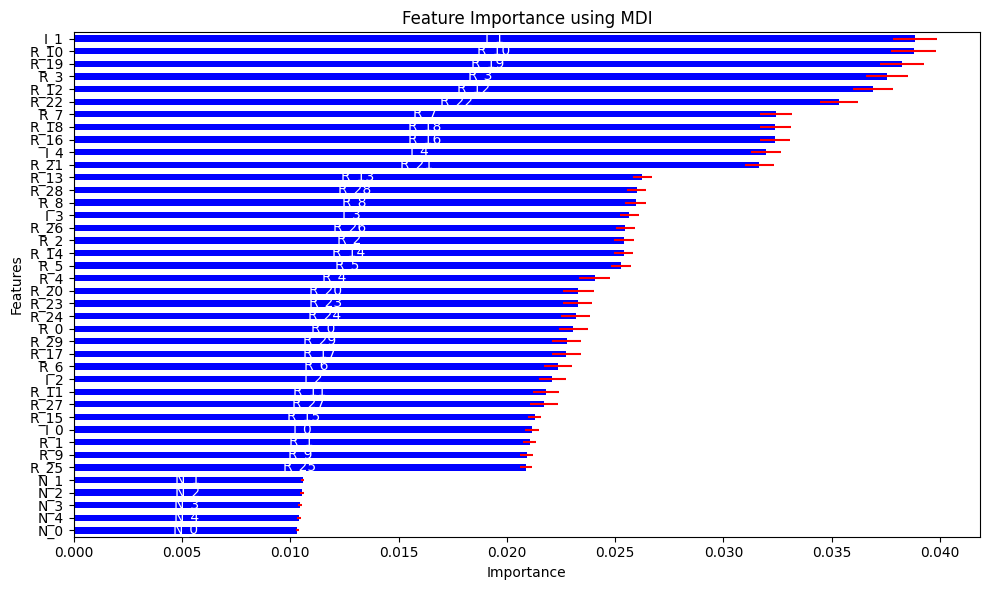

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from typing import Literal

def get_mdi_importance(tree_cls_fit, feature_names:list):
    importance_dict={i:tree.feature_importances_ for i, tree in enumerate(tree_cls_fit.estimators_)}
    importance_df=pd.DataFrame.from_dict(importance_dict, orient='index', columns=feature_names)
    importance_df=importance_df.replace(0, np.nan)
    ret=pd.concat({'mean': importance_df.mean(), 'std': importance_df.std()/np.sqrt(importance_df.shape[0])}, axis=1)
    ret/=ret['mean'].sum() # normalization
    return ret

def plot_feature_importance(imp:pd.DataFrame, method_name:Literal['MDI', 'MDA']):
    plt.figure(figsize=(10, 6))
    imp=imp.sort_values('mean', ascending=True)
    ax=imp['mean'].plot(xerr=imp['std'], error_kw={'ecolor':'r'}, color='b', kind='barh')
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2, j, ha='center', va='center', color='white', fontsize=10)
    plt.title(f'Feature Importance using {method_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

X, y=get_test_data(40, 5, 30, 10000, 0.1)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(estimator=clf, n_estimators=1000, n_jobs=-1, max_features=1.0, max_samples=1.0, oob_score=False)
fit=clf.fit(X, y)
importance_df=get_mdi_importance(fit, X.columns)
plot_feature_importance(importance_df, 'MDI')



6.3 Implementation of MDA(Mean Decrease Accuracy) Method

각 feature를 shuffle 했을때 OOS의 성능 하락량을 통해서 feature importance를 측정하는 방법

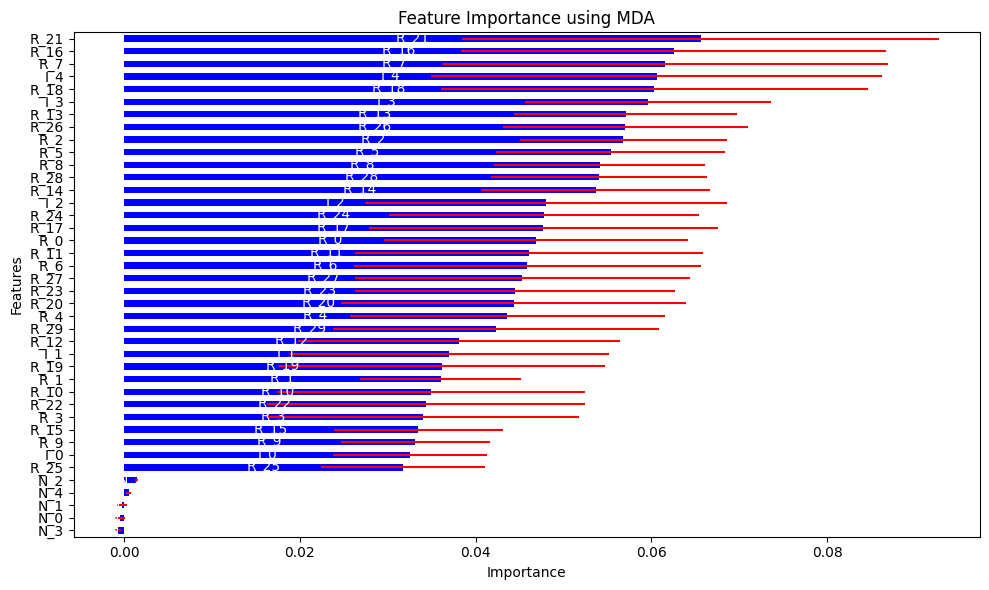

In [7]:
from sklearn.model_selection._split import KFold
from sklearn.metrics import log_loss

def get_mda_importance(clf, X:pd.DataFrame, y:pd.Series, n_splits=5):
    cv_gen=KFold(n_splits=n_splits, shuffle=False)
    score_ori, score_shuffle=pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train_idx, test_idx) in enumerate(cv_gen.split(X)):
        X_train, y_train=X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test=X.iloc[test_idx, :], y.iloc[test_idx]
        fit=clf.fit(X_train, y_train)
        p_ori=fit.predict_proba(X_test)
        score_ori[i]=-log_loss(y_test, p_ori, labels=clf.classes_)
        for col in X.columns:
            X_test_shuffled=X_test.copy(deep=True)
            np.random.shuffle(X_test_shuffled[col].values)
            p_shuffled=fit.predict_proba(X_test_shuffled)
            score_shuffle.loc[i, col]=-log_loss(y_test, p_shuffled, labels=clf.classes_)
    imp=(-score_shuffle).add(score_ori, axis=0)
    imp/=(-score_shuffle) # (original-shuffled)/-shuffled (log loss에 음수 붙여준 것을 생각)
    imp=pd.concat({'mean': imp.mean(), 'std': imp.std()/np.sqrt(imp.shape[0])}, axis=1)
    return imp

importance_df_mda=get_mda_importance(clf, X, y)
plot_feature_importance(importance_df_mda, 'MDA')

6.4 Clustered MDI

Basic한 MDI의 경우 feature의 중요도는 판단할 수 있지만 해당 feature의 redundant한 feature가 많은 경우 해석력이 떨어지기 때문에 feature들을 하나로 묶어서 
cluster 자체의 중요도를 판단하여 feature들의 중요도를 판단하는 방법

In [8]:
def get_mdi_importance_cluster(tree_cls_fit, feature_names:list, cluster_dict:dict):
    def get_cluster_mean_std(importance_df:pd.DataFrame, cluster_dict:dict):
        ret=pd.DataFrame(columns=['mean', 'std'])
        for cluster, features in cluster_dict.items():
            cluster_importance=importance_df[features].sum(axis=1) # cluster의 중요도는 해당 cluster에 속한 feature들의 중요도를 합한 것
            ret.loc[f'C_{cluster}']=[cluster_importance.mean(), cluster_importance.std()/np.sqrt(cluster_importance.count())]
        return ret
    importance_dict={i:tree.feature_importances_ for i, tree in enumerate(tree_cls_fit.estimators_)}
    importance_df=pd.DataFrame.from_dict(importance_dict, orient='index', columns=feature_names)
    importance_df=importance_df.replace(0, np.nan)
    ret=get_cluster_mean_std(importance_df, cluster_dict)
    ret/=ret['mean'].sum()  # normalization    
    return ret

6.5 Clusterd MDA

In [9]:
def get_mda_importance_cluster(clf, X:pd.DataFrame, y:pd.Series, cluster_dict:dict , n_splits=5):
    cv_gen=KFold(n_splits=n_splits, shuffle=False)
    score_ori, score_shuffle=pd.Series(), pd.DataFrame(columns=list(cluster_dict.keys()))
    for i, (train_idx, test_idx) in enumerate(cv_gen.split(X)):
        X_train, y_train=X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test=X.iloc[test_idx, :], y.iloc[test_idx]
        fit=clf.fit(X_train, y_train)
        p_ori=fit.predict_proba(X_test)
        score_ori[i]=-log_loss(y_test, p_ori, labels=clf.classes_)
        for col in cluster_dict.keys():
            X_test_shuffled=X_test.copy(deep=True)
            for feature in cluster_dict[col]: # cluster 전체를 shuffle하는 구조
                np.random.shuffle(X_test_shuffled[feature].values)
            p_shuffled=fit.predict_proba(X_test_shuffled)
            score_shuffle.loc[i, col]=-log_loss(y_test, p_shuffled, labels=clf.classes_)
    imp=(-score_shuffle).add(score_ori, axis=0)
    imp/=(-score_shuffle) # (original-shuffled)/-shuffled (log loss에 음수 붙여준 것을 생각)
    imp=pd.concat({'mean': imp.mean(), 'std': imp.std()/np.sqrt(imp.shape[0])}, axis=1)
    imp.index=[f'C_{i}' for i in range(len(imp.index))]  # cluster index로 변경
    return imp

6.6 Experimental Result

<Axes: >

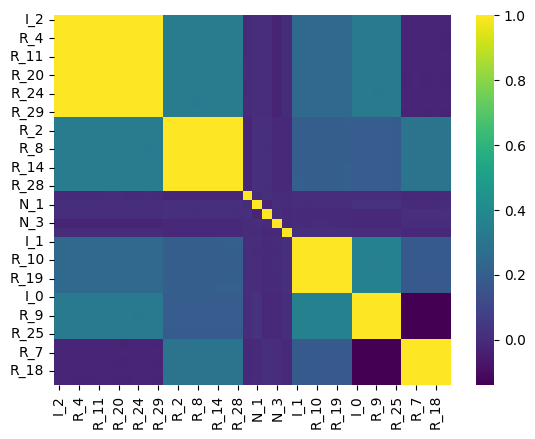

In [11]:
from optimized_kmean_clustering import KMeansClustering
import seaborn as sns

kmeans = KMeansClustering()
corr, cluster_dict, sil_score = kmeans.cluster_kmeans_top(X.corr(), max_num_clusters=10, n_init=10)

sns.heatmap(corr, cmap='viridis')

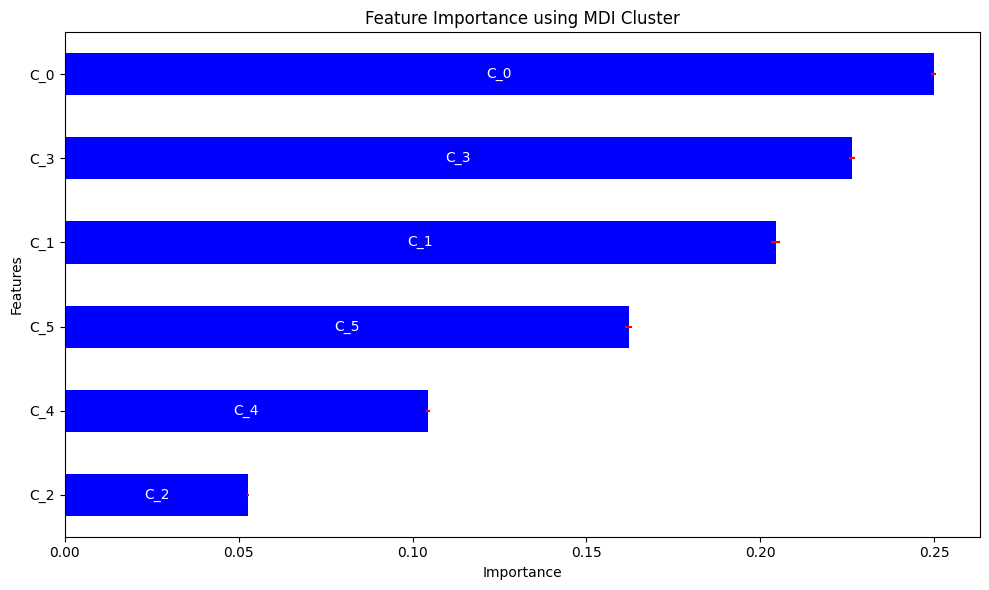

In [12]:
fit=clf.fit(X, y)
importance_df_mdi_cluster=get_mdi_importance_cluster(fit, X.columns, cluster_dict)
plot_feature_importance(importance_df_mdi_cluster, 'MDI Cluster')

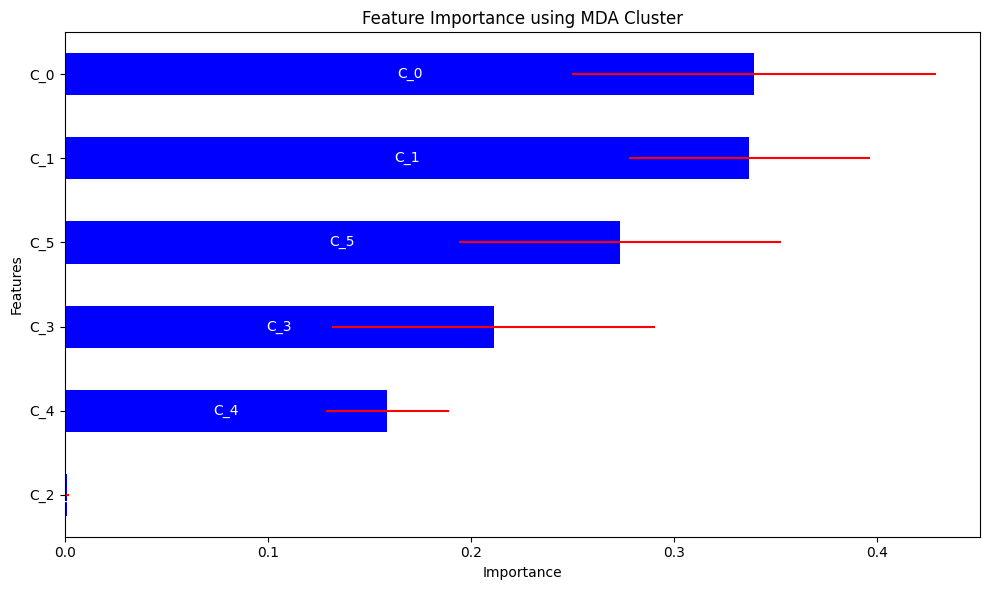

In [13]:
importance_df_mda_cluster=get_mda_importance_cluster(clf, X, y, cluster_dict)
plot_feature_importance(importance_df_mda_cluster, 'MDA Cluster')
